In [1]:
# libraries
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.stattools import acf, adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.svm import SVR
from tqdm import tqdm
from collections import defaultdict
import holidays
import matplotlib.pyplot as plt
import seaborn as sns

# read in data

data downloaded from:

 - https://zenodo.org/record/5946808#.ZGNpddbP23I
 - https://zenodo.org/record/5841834#.ZGNpTNbP23J

### Wind data

##### Status data

In [3]:
# read in files
turbine_status = pd.read_csv('../data/Wind/Kelmarsh/Status_Kelmarsh_1_2016-01-03_-_2017-01-01_228.csv',
                             skiprows = 9)

In [74]:
turbine_status.head()

Index(['Timestamp start', 'Timestamp end', 'Duration', 'Status', 'Code',
       'Message', 'Comment', 'Service contract category', 'IEC category'],
      dtype='object')


,Timestamp start,Timestamp end,Duration,Status,Code,Message,Comment,Service contract category,IEC category
0,2016-01-14 19:28:03,2016-01-23 14:36:32,211:08:29,Stop,111,Emergency stop nacelle,NaN,Emergency stop switch (Nacelle) (11),Forced outage
1,2016-01-14 19:28:03,2016-01-14 19:38:03,00:10:00,Warning,5720,Brake accumulator defect,NaN,Warnings (27),NaN
2,2016-01-14 19:28:05,2016-01-23 11:27:46,207:59:41,Informational,3835,Cable panel breaker open,NaN,Warnings (27),NaN
3,2016-01-14 19:28:05,2016-01-23 11:27:46,207:59:41,Informational,3830,Supply circuit breaker earthed,NaN,Warnings (27),Full Performance
4,2016-01-14 19:28:05,2016-01-23 14:09:18,210:41:13,Warning,3870,Overload transformer fan outlet air,NaN,Warnings (27),Full Performance


In [5]:
turbine_status['IEC category'].unique()

array(['Forced outage', nan, 'Full Performance', 'Technical Standby',
       'Scheduled Maintenance', 'Partial Performance',
       'Out of Environmental Specification', 'Requested Shutdown',
       'Out of Electrical Specification'], dtype=object)

The maintenance dates can be utilised in the forecsting process as the dates since the last maintenance to see if there is any wearoff

##### Turbine Data

In [39]:
test = pd.read_csv('../data/Wind/Kelmarsh/Turbine_Data_Kelmarsh_1_2016-01-03_-_2017-01-01_228.csv',
                             skiprows = 9)                             

In [40]:
print(test.columns.values)

['# Date and time' 'Wind speed (m/s)'
 'Wind speed, Standard deviation (m/s)' 'Wind speed, Minimum (m/s)'
 'Wind speed, Maximum (m/s)' 'Long Term Wind (m/s)'
 'Wind speed Sensor 1 (m/s)'
 'Wind speed Sensor 1, Standard deviation (m/s)'
 'Wind speed Sensor 1, Minimum (m/s)' 'Wind speed Sensor 1, Maximum (m/s)'
 'Wind speed Sensor 2 (m/s)'
 'Wind speed Sensor 2, Standard deviation (m/s)'
 'Wind speed Sensor 2, Minimum (m/s)' 'Wind speed Sensor 2, Maximum (m/s)'
 'Density adjusted wind speed (m/s)' 'Wind direction (°)'
 'Nacelle position (°)' 'Wind direction, Standard deviation (°)'
 'Wind direction, Minimum (°)' 'Wind direction, Maximum (°)'
 'Nacelle position, Standard deviation (°)'
 'Nacelle position, Minimum (°)' 'Nacelle position, Maximum (°)'
 'Vane position 1+2 (°)' 'Vane position 1+2, Max (°)'
 'Vane position 1+2, Min (°)' 'Vane position 1+2, StdDev (°)'
 'Energy Export (kWh)' 'Energy Export counter (kWh)' 'Energy Import (kWh)'
 'Energy Import counter (kWh)' 'Lost Production (Con

,# Date and time,Wind speed (m/s),"Wind speed, Standard deviation (m/s)","Wind speed, Minimum (m/s)","Wind speed, Maximum (m/s)",Long Term Wind (m/s),Wind speed Sensor 1 (m/s),"Wind speed Sensor 1, Standard deviation (m/s)","Wind speed Sensor 1, Minimum (m/s)","Wind speed Sensor 1, Maximum (m/s)",...,Tower Acceleration y (mm/ss),"Tower Acceleration X, Min (mm/ss)","Tower Acceleration X, Max (mm/ss)","Tower Acceleration Y, Min (mm/ss)","Tower Acceleration Y, Max (mm/ss)","Drive train acceleration, Max (mm/ss)","Drive train acceleration, Min (mm/ss)","Drive train acceleration, StdDev (mm/ss)","Tower Acceleration X, StdDev (mm/ss)","Tower Acceleration Y, StdDev (mm/ss)"
0,2016-01-03 00:00:00,NaN,NaN,NaN,NaN,7.1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-03 00:10:00,NaN,NaN,NaN,NaN,7.1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03 00:20:00,NaN,NaN,NaN,NaN,7.1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-03 00:30:00,NaN,NaN,NaN,NaN,7.1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-03 00:40:00,NaN,NaN,NaN,NaN,7.1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
def reading_Windturbines(turbine_directory):

    def safe_datetime_conversion(s):
        try:
            return pd.to_datetime(s)
        except:
            return pd.NaT

    def days_since_last_maintenance(row_date, maintenance_dates):
        # Exclude None values from the maintenance_dates list before making comparisons
        preceding_maintenance_dates = [date for date in maintenance_dates if date is not None and date <= row_date]
        if not preceding_maintenance_dates:
            return float('NaN')
        last_maintenance_date = max(preceding_maintenance_dates)
        delta = (row_date - last_maintenance_date).days
        return delta

    # Columns to keep
    columns_turbine = [
        '# Date and time',
        'Wind speed (m/s)',
        'Long Term Wind (m/s)',
        'Power (kW)'
    ]
    columns_status = [
        'Timestamp end',
        'IEC category'
    ]

    # Directory containing CSV files
    directory = f'../data/Wind/{turbine_directory}/'

    # Dictionary to hold DataFrames for each turbine
    turbine_dataframes = defaultdict(list)
    status_lists = defaultdict(list)

    # Get a list of CSV files in the directory
    turbine_files = [f for f in os.listdir(directory) if f.startswith(f"Turbine_Data_{turbine_directory}_") and f.endswith(".csv")]
    status_files = [f for f in os.listdir(directory) if f.startswith(f"Status_{turbine_directory}_") and f.endswith(".csv")]

    # Iterate through the status files
    for filename in tqdm(status_files, desc='Processing status files'):
        turbine_number = filename.split("_")[2]
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath, skiprows=9, usecols=columns_status)
        df['Timestamp end'] = df['Timestamp end'].apply(safe_datetime_conversion)
        maintenance_dates = df[df['IEC category'] == 'Scheduled Maintenance']['Timestamp end'].apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isna(x) else None).unique()
        status_lists[turbine_number].extend(maintenance_dates)

    # Iterate through the turbine files
    for filename in tqdm(turbine_files, desc='Processing turbine files'):
        turbine_number = filename.split("_")[3]
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath, skiprows=9, usecols=columns_turbine)
        df['# Date and time'] = pd.to_datetime(df['# Date and time'])
        maintenance_dates = [pd.to_datetime(date) for date in status_lists[turbine_number]]
        df['Days Since Maintenance'] = df['# Date and time'].apply(lambda row_date: days_since_last_maintenance(row_date, maintenance_dates))
        turbine_dataframes[turbine_number].append(df)

    # Concatenate the DataFrames for each turbine
    for turbine_number, dfs in turbine_dataframes.items():
        turbine_dataframes[turbine_number] = pd.concat(dfs)
        turbine_dataframes[turbine_number].sort_values('# Date and time', inplace=True)
        turbine_dataframes[turbine_number] = turbine_dataframes[turbine_number].reset_index(drop=True)
        turbine_dataframes[turbine_number].set_index(pd.to_datetime(turbine_dataframes[turbine_number]['# Date and time']), inplace=True)

    print("\n dictionary keys:")
    print(turbine_dataframes.keys())
    print('\n shape for exemplary key:')
    print(turbine_dataframes[list(turbine_dataframes.keys())[0]].shape)

    return turbine_dataframes

In [64]:
Kelmarsh_df = reading_Windturbines('Kelmarsh')

Processing turbine files: 100%|██████████| 36/36 [01:32<00:00,  2.57s/it]



 dictionary keys:
dict_keys(['6', '1', '3', '2', '4', '5'])

 shape for exemplary key:
(288864, 5)


In [79]:
Penmanshiel_df = reading_Windturbines('Penmanshiel')

Processing files: 100%|██████████| 84/84 [00:30<00:00,  2.78it/s]


 dictionary keys:
dict_keys(['07', '08', '02', '05', '06', '15', '10', '14', '01', '04', '11', '12', '13', '09'])

 Information for exemplary key:
shape
(267014, 4)

 missing values
# Date and time            0
Wind speed (m/s)        5881
Long Term Wind (m/s)       0
Power (kW)              5881
dtype: int64


### Fraunhofer Data

In [80]:
# read in files
ENIT_2022_1 = pd.read_csv('../data/Fraunhofer/ENIT_1_2022.csv', sep=';', decimal=',')
ENIT_2022_2 = pd.read_csv('../data/Fraunhofer/ENIT_2_2022.csv', sep=';', decimal=',')
ENIT_2023_1 = pd.read_csv('../data/Fraunhofer/ENIT_1_2023.csv', sep=';', decimal=',')

# merge files
ENIT_df = pd.concat([ENIT_2022_1, ENIT_2022_2, ENIT_2023_1])

del ENIT_2022_1, ENIT_2022_2, ENIT_2023_1

In [81]:
# rename columns
ENIT_df.columns = ENIT_df.columns.str.replace('Wirkarbeit (Bezug) ', '').str.strip()

# add residual columns
ENIT_df['1.8 - Residual'] = ENIT_df.iloc[:, 1] - ENIT_df.iloc[:, 2:8].sum(axis=1)
ENIT_df['2.7 - Residual'] = ENIT_df.iloc[:, 9] - ENIT_df.iloc[:, 10:15].sum(axis=1)
ENIT_df['0.1 - Residual'] = ENIT_df.iloc[:, 16] - ENIT_df.iloc[:, 1] - ENIT_df.iloc[:, 9]

# change time to dateformat
ENIT_df['Zeitstempel'] = pd.to_datetime(ENIT_df['Zeitstempel'], format='%d.%m.%Y %H:%M:%S')

# reset index
ENIT_df = ENIT_df.reset_index(drop=True)

ENIT_df.set_index(ENIT_df['Zeitstempel'], inplace=True)   

In [82]:
# data as dict with each company as a key
FraunhoferData = {
    'Hiller': ENIT_df
}

del ENIT_df

In [83]:
def FraunhoferData_descriptive (df):
    # Calculate the mean and standard deviation for each column
    mean = ENIT_df.iloc[:, 1:15].mean()
    std_dev = ENIT_df.iloc[:, 1:15].std()

    # Identify outliers using twice the standard deviation
    outliers = (ENIT_df.iloc[:, 1:15] < (mean - 2 * std_dev)) | (ENIT_df.iloc[:, 1:15] > (mean + 2 * std_dev))

    # Print the number of True values in each column
    print("Number of outliers in each column:")
    print(outliers.sum())

    # Get the row and column indices of the True values
    true_values_indices = outliers.where(outliers).stack().index

    # Print the row and column indices of the True values
    print("\nIndices of outliers:")
    for row, col in true_values_indices:
        print(f"Row: {row}, Column: {col}")

    # NA values
    print("\nNumber of missing Values:")
    print(ENIT_df.isna().sum())


# graphs

In [84]:
def graph_plotting(df, timestamp, dependent_var, df_type):
    plt.figure(figsize=(10,6))

    # Plot the time series
    plt.plot(df.index, df[dependent_var])

    # Identify and mark missing values with red vertical lines
    missing_values = df[df[dependent_var].isnull()]
    for x_val in missing_values.index:
        plt.axvline(x=x_val, color='red', linestyle='-', linewidth=0.8, alpha = 0.1)
    
    # Identify and mark outliers with blue vertical lines (for demonstration, Z-score > 3 considered as outlier)
    z_scores = (df[dependent_var] - df[dependent_var].mean()) / df[dependent_var].std()
    outliers = df[np.abs(z_scores) > 3]
    for x_val in outliers.index:
        plt.axvline(x=x_val, color='blue', linestyle='-', linewidth=0.8, alpha = 0.1)

    # Formatting x-axis
    plt.xticks(rotation=45)

    plt.tight_layout()

    if df_type == 'Windturbine':
        title_str = f"Windturbine - Time Series"
        y_label = "Output in kWh"
    elif df_type == 'FlexGuide':
        title_str = f"FlexGuide - Time Series"
        y_label = "Consumption in Wh"
    else:
        title_str = f"Time Series"
        y_label = "Value"

    plt.title(title_str)
    plt.ylabel(y_label)
    plt.xlabel("Date")

    plt.savefig(f"../graphs/{title_str}.png")

    plt.show()

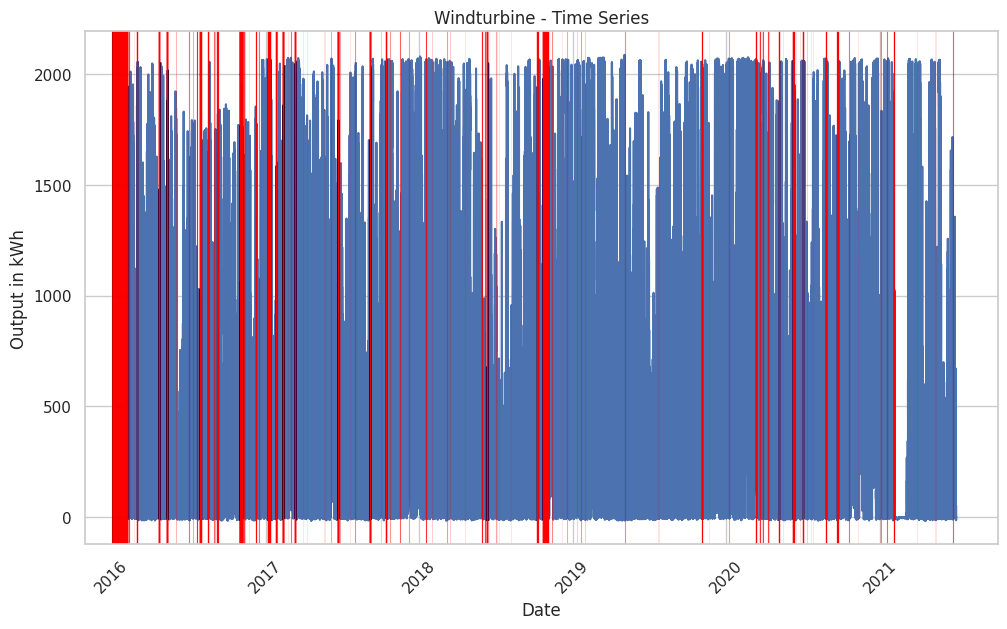

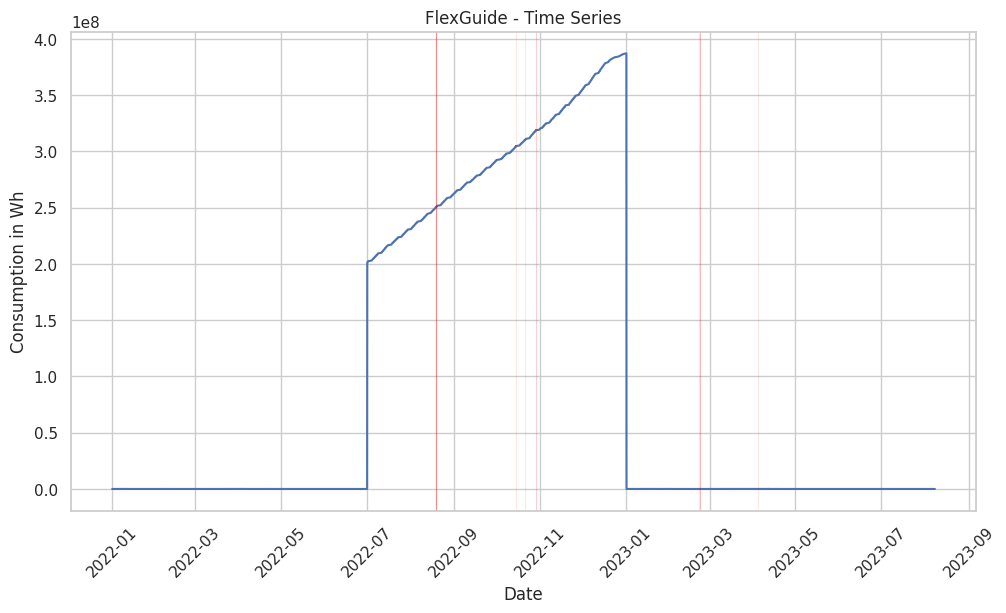

In [85]:
graph_plotting(Kelmarsh_df['6'], '# Date and time', 'Power (kW)', 'Windturbine')

graph_plotting(FraunhoferData['Hiller'], 'Zeitstempel', '1.0 - Trafo 1 [Wh]', 'FlexGuide')

In [86]:
FraunhoferData['Hiller'].head()

,Zeitstempel,1.0 - Trafo 1 [Wh],"1.1 - Neubau, Wohnhaus, Holzplatz [Wh]",1.2 - Halle 3/1 Absaugung [Wh],1.3 - Halle 4/2 Maschinensaal/Tischfertigung [Wh],"1.4 - Halle 2/2 Verwaltung, Entwicklung [Wh]",1.5 - Halle 4/5 Lackieranlage [Wh],1.6 - Halle 1/6 Hausmeister [Wh],"1.7 - Halle 3/3 Kompressor, Stuhlmontage [Wh]",2.0 - Trafo 2 [Wh],2.1 - Halle 4/5 Schrankfertigung [Wh],2.2 - Halle 2/4 Rilsan [Wh],2.3 - Halle 4/5 Stahlstuhl [Wh],2.4 - Halle 4/1 Schichtholz [Wh],2.5 - Halle 4/1 Absaugung Schichtholz [Wh],2.6 - Halle 3/6a Schlatter [Wh],Übergabezähler [Wh],1.8 - Residual,2.7 - Residual,0.1 - Residual
Zeitstempel,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:15:00,2022-01-01 00:15:00,2490.59,820.04,30.04,596.89,3064.04,0.11,136.98,205.81,3960.94,250.94,547.34,598.18,64.50,54.85,0.0,0.0,-2157.51,2445.13,-6451.53
2022-01-01 00:30:00,2022-01-01 00:30:00,2416.07,677.48,29.32,651.33,3050.03,0.06,90.86,202.52,3872.87,279.26,537.12,571.65,63.96,53.31,0.0,0.0,-2083.01,2367.57,-6288.94
2022-01-01 00:45:00,2022-01-01 00:45:00,2410.21,640.79,29.18,752.23,3020.57,0.10,92.29,194.06,3874.72,275.07,529.85,551.04,63.60,53.24,0.0,20000.0,-2124.95,2401.92,13715.07
2022-01-01 01:00:00,2022-01-01 01:00:00,2525.85,715.91,29.27,612.53,3324.27,0.03,115.20,197.47,4035.20,276.31,537.56,553.50,63.96,53.54,0.0,0.0,-2271.36,2550.33,-6561.05
2022-01-01 01:15:00,2022-01-01 01:15:00,2534.66,657.07,29.32,710.75,3322.08,0.04,110.17,202.56,4052.54,275.54,531.48,548.32,63.81,53.24,0.0,0.0,-2294.77,2580.15,-6587.20


In [87]:
def graph_plotting_date(df, timestamp, dependent_var, start_date, end_date):
    subset_df = df[start_date:end_date]

    plt.figure(figsize=(10,6))

    plt.plot(subset_df.index, subset_df[dependent_var])

    # Formatting x-axis
    plt.xticks(rotation=45)

    plt.tight_layout()
    title_str = f"Hiller - Time Series for {start_date} to {end_date}"
    plt.title(title_str)
    plt.ylabel("Consumption in Wh")
    plt.xlabel("Date")

    # Save the figure before showing it
    plt.savefig(f"../graphs/{title_str}.png")

    plt.show()

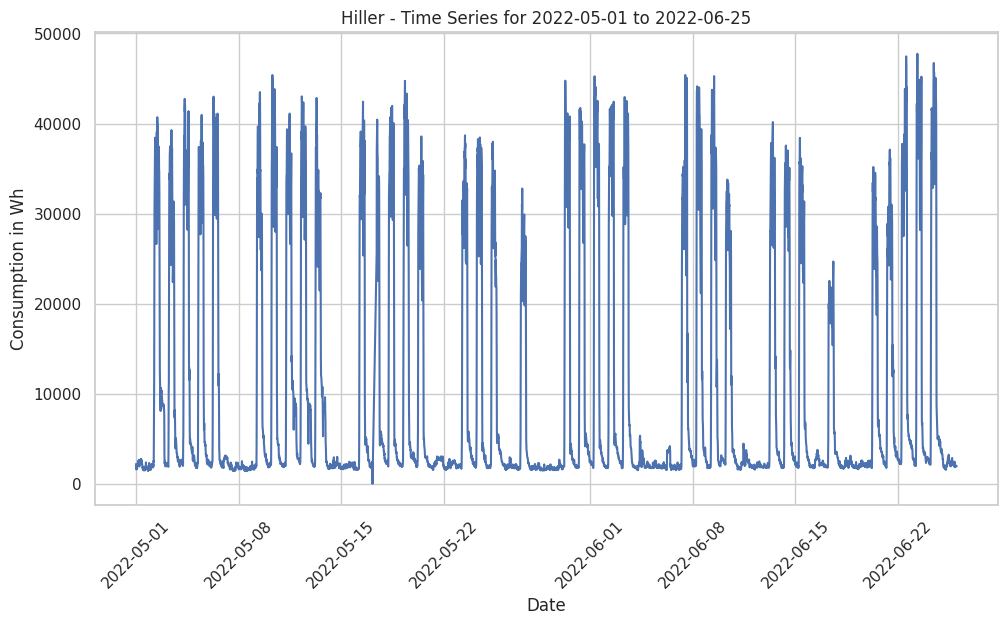

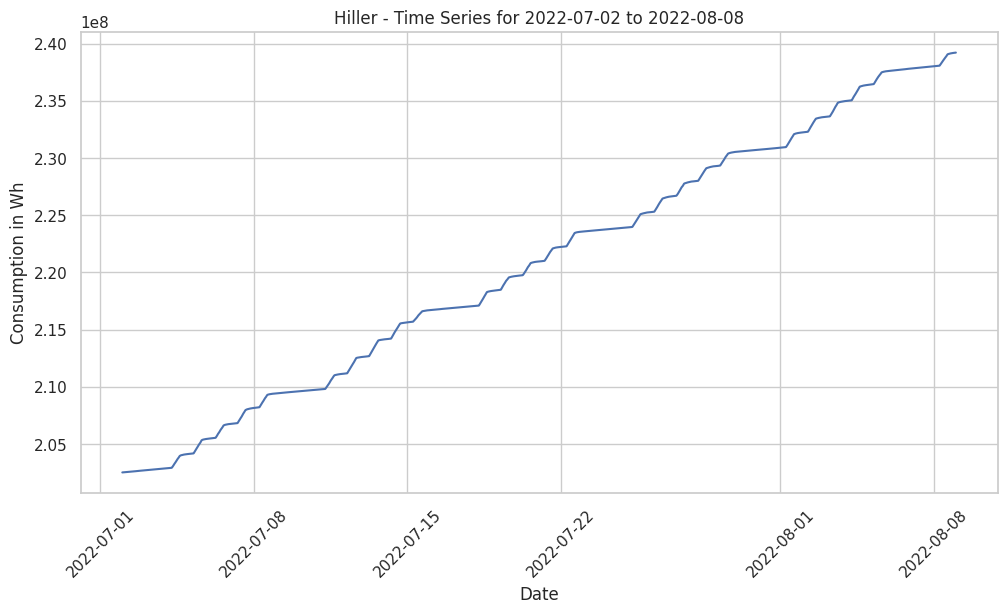

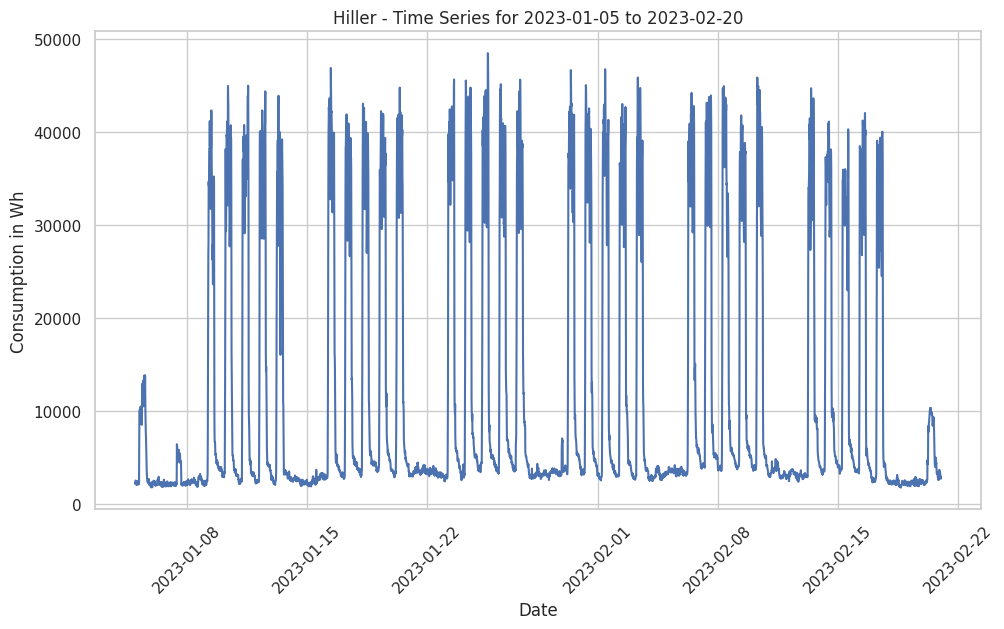

In [88]:
# before spike
graph_plotting_date(
    FraunhoferData['Hiller'],
    'Zeitstempel',
    '1.0 - Trafo 1 [Wh]',
    '2022-05-01',
    '2022-06-25'
)

# linear increase
graph_plotting_date(
    FraunhoferData['Hiller'],
    'Zeitstempel',
    '1.0 - Trafo 1 [Wh]',
    '2022-07-02',
    '2022-08-08'
)

# after drop
graph_plotting_date(
    FraunhoferData['Hiller'],
    'Zeitstempel',
    '1.0 - Trafo 1 [Wh]',
    '2023-01-05',
    '2023-02-20'
)

# pre-processing pipeline

### outlier detection

In [89]:
def outlier_detection(data, dependent_var):
    # Only keep the specified columns
    df = data[[f'{dependent_var}']]

    # Calculate the mean and standard deviation for each column
    mean = df.mean()
    std_dev = df.std()

    # Calculate the z-scores for each value
    z_scores = (df - mean) / std_dev

    # Identify outliers using a threshold of 3 for z-scores
    outliers = (z_scores < -3) | (z_scores > 3)

    # Print the number of True values in each column
    print("Number of outliers in each column:")
    print(outliers.sum())
    '''
    # Get the row and column indices of the True values
    true_values_indices = outliers.where(outliers).stack().index

    # Print the row and column indices of the True values along with their z-scores
    print("\nIndices of outliers and their z-scores:")
    for row, col in true_values_indices:
        print(f"Row: {row}, Column: {col}, Z-Score: {z_scores.loc[row, col]}")
    '''
def Fraunhofer_descriptive (df):
    # Calculate the mean and standard deviation for each column
    mean = df.iloc[:, 1:15].mean()
    std_dev = df.iloc[:, 1:15].std()

    # Identify outliers using twice the standard deviation
    outliers = (df.iloc[:, 1:15] < (mean - 2 * std_dev)) | (df.iloc[:, 1:15] > (mean + 2 * std_dev))

    # Print the number of True values in each column
    print("Number of outliers in each column:")
    print(outliers.sum())
    '''
    # Get the row and column indices of the True values
    true_values_indices = outliers.where(outliers).stack().index

    # Print the row and column indices of the True values
    print("\nIndices of outliers:")
    for row, col in true_values_indices:
        print(f"Row: {row}, Column: {col}")
    '''
    # NA values
    print("\nNumber of missing Values:")
    print(df.isna().sum())

In [90]:
def check_missing_sequences(df, column='Power (kW)'):
    # Initialize variables to hold information
    sequences = []
    current_sequence = 0
    long_sequence_indices = []
    start_index = None
    
    # Loop through the DataFrame to find missing values
    for i, row in df.iterrows():
        if pd.isnull(row[column]):
            current_sequence += 1
            if start_index is None:
                start_index = i
        else:
            if current_sequence >= 19:  # A long sequence
                long_sequence_indices.extend(pd.date_range(start=start_index, periods=current_sequence, freq='10T'))
            if current_sequence > 0:
                sequences.append(current_sequence)
            current_sequence = 0
            start_index = None
    
    # Don't forget the last sequence if it exists
    if current_sequence > 0:
        sequences.append(current_sequence)
        if current_sequence >= 19:  # A long sequence
            long_sequence_indices.extend(pd.date_range(start=start_index, periods=current_sequence, freq='10T'))
        
    # Classify sequences as short or long
    short_sequences = [s for s in sequences if s < 19]
    long_sequences = [s for s in sequences if s >= 19]
    
    print(f"Short sequences of missing values (3 hours or less): {len(short_sequences)}")
    print(f"Long sequences of missing values (more than 3 hours): {len(long_sequences)}")
    
    # If you want to see the actual lengths
    print(f"Lengths of short sequences: \n {pd.Series(short_sequences).value_counts()}")
    print(f"Lengths of long sequences: \n {pd.Series(long_sequences).value_counts()}")

    # Remove the rows corresponding to long sequences
    df.drop(long_sequence_indices, inplace=True)


In [91]:
def process_data_frames(df_dict, dependent_var):
    for key in df_dict.keys():
        print(f"Processing DataFrame: {key}")
        
        # Perform outlier detection
        print("outlier detection...")
        outlier_detection(df_dict[key], dependent_var)
        
        # Check for missing sequences
        print(" missing values detection & removal...")
        check_missing_sequences(df_dict[key], dependent_var)

process_data_frames(Kelmarsh_df, 'Power (kW)')

Processing DataFrame: 6
outlier detection...
Number of outliers in each column:
Power (kW)    0
dtype: int64
 missing values detection & removal...
Short sequences of missing values (3 hours or less): 111
Long sequences of missing values (more than 3 hours): 37
Lengths of short sequences: 
 1     53
2     15
3      9
4      7
5      6
8      6
6      3
18     2
11     2
9      2
14     2
15     1
12     1
13     1
7      1
Name: count, dtype: int64
Lengths of long sequences: 
 42      2
29      2
35      2
130     2
53      2
25      2
144     1
66      1
20      1
124     1
4842    1
1528    1
166     1
22      1
26      1
41      1
36      1
149     1
77      1
74      1
30      1
28      1
90      1
70      1
84      1
188     1
34      1
44      1
169     1
120     1
39      1
Name: count, dtype: int64
Processing DataFrame: 4
outlier detection...
Number of outliers in each column:
Power (kW)    0
dtype: int64
 missing values detection & removal...
Short sequences of missing values 

In [92]:
Fraunhofer_descriptive(FraunhoferData['Hiller'])

Number of outliers in each column:
1.0 - Trafo 1 [Wh]                                   0
1.1 - Neubau, Wohnhaus, Holzplatz [Wh]               0
1.2 - Halle 3/1 Absaugung [Wh]                       0
1.3 - Halle 4/2 Maschinensaal/Tischfertigung [Wh]    0
1.4 - Halle 2/2 Verwaltung, Entwicklung [Wh]         0
1.5 - Halle 4/5 Lackieranlage [Wh]                   0
1.6 - Halle 1/6 Hausmeister [Wh]                     0
1.7 - Halle 3/3 Kompressor, Stuhlmontage [Wh]        0
2.0 - Trafo 2 [Wh]                                   0
2.1 - Halle 4/5 Schrankfertigung [Wh]                0
2.2 - Halle 2/4 Rilsan [Wh]                          0
2.3 - Halle 4/5 Stahlstuhl [Wh]                      0
2.4 - Halle 4/1 Schichtholz [Wh]                     0
2.5 - Halle 4/1 Absaugung Schichtholz [Wh]           0
dtype: int64

Number of missing Values:
Zeitstempel                                             0
1.0 - Trafo 1 [Wh]                                     15
1.1 - Neubau, Wohnhaus, Holzplatz [Wh] 

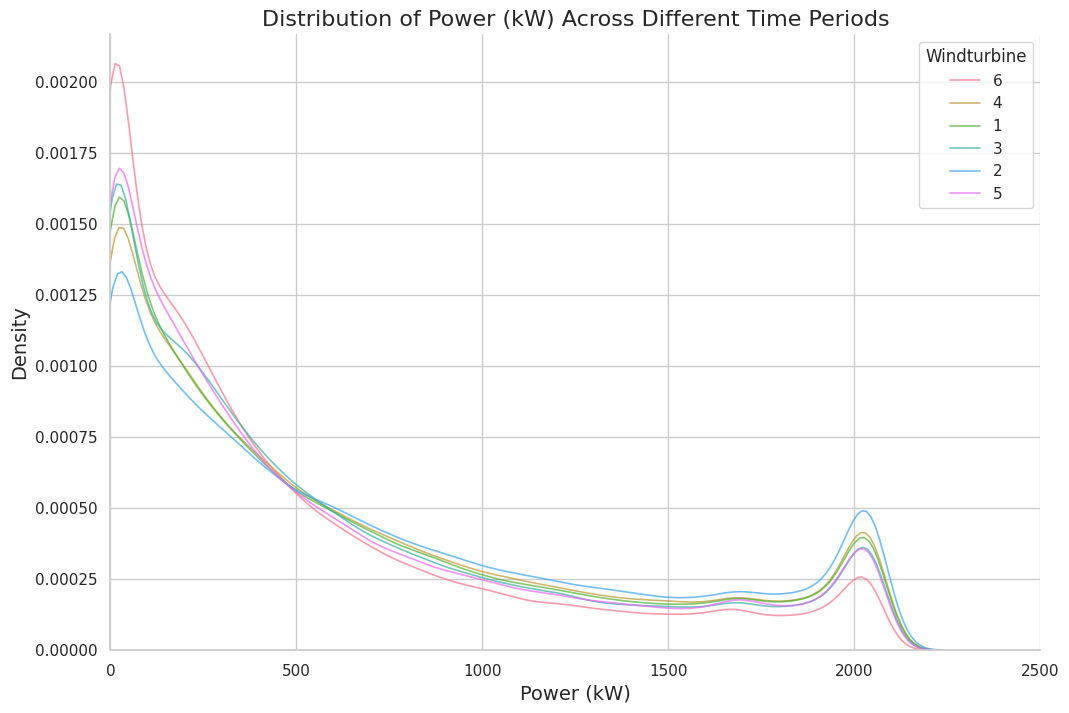

In [94]:
# Set the style
sns.set(style="whitegrid")

# Create a color palette with different colors for each key
palette = sns.color_palette("husl", len(Kelmarsh_df))

# Create a figure
fig, ax = plt.subplots(figsize=(12, 8))

# Loop through each key in Kelmarsh_df to plot the distributions
for key, color in zip(Kelmarsh_df.keys(), palette):
    sns.kdeplot(Kelmarsh_df[key]['Power (kW)'], fill=False, common_norm=False, color=color, alpha=.7, linewidth=1.2, label=key)
        # Set common x and y limits
    ax.set_xlim(0,2500)

# Set plot title and labels
ax.set_title('Distribution of Power (kW) Across Different Time Periods', fontsize=16)
ax.set_xlabel('Power (kW)', fontsize=14)
ax.set_ylabel('Density', fontsize=14)

# Add legend
ax.legend(title='Windturbine')

# Remove the top and right spines from the plot
sns.despine()

# Show the plot
plt.savefig("../graphs/Kelmarsh_output_distribution")
plt.show()


### wind & energy output

In [103]:
def wind_energy_corr(df):
    print(f"correlation between wind speed and energy export is: \n {df['Power (kW)'].corr(df['Wind speed (m/s)']):.4f}")

    # list of values turbines "aus dem Wind gedreht"
    # Filter rows where 'Wind speed (m/s)' is greater than 1 and 'Power (kW)' is 0
    filtered_df = df[(df['Wind speed (m/s)'] > 3) & (df['Power (kW)'] < 1)]

    # Get the total number of occurrences
    print(f"Turbine was 'aus dem Wind gedreht': \n {len(filtered_df)}")

    # delete wrong rows
    df = df.drop(filtered_df.index.tolist())

    # Scatter Plot
    plt.figure(figsize=(10, 6))
    sns.jointplot(data=df[-10000:], x='Wind speed (m/s)', y='Power (kW)')
    #plt.title('Energy Export vs. Wind Speed')
    plt.show()
    plt.savefig("../graphs/Correlation_Wind_Energy.png")

Windturbine #6
correlation between wind speed and energy export is: 
 0.9074
Turbine was 'aus dem Wind gedreht': 
 8705


<Figure size 1000x600 with 0 Axes>

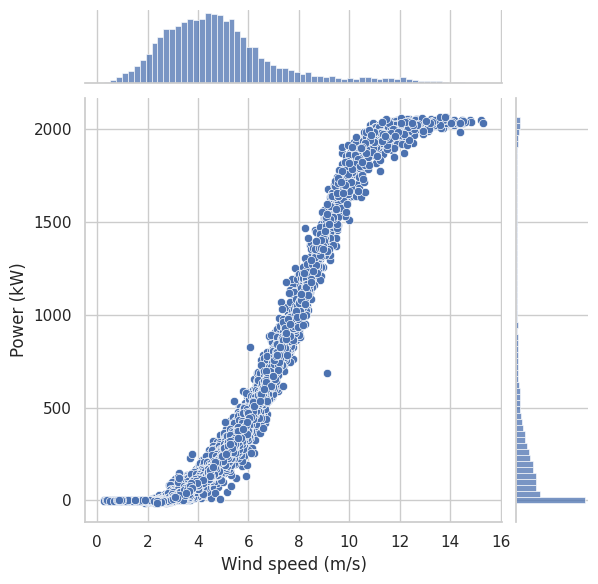

Windturbine #4
correlation between wind speed and energy export is: 
 0.9276
Turbine was 'aus dem Wind gedreht': 
 4195


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

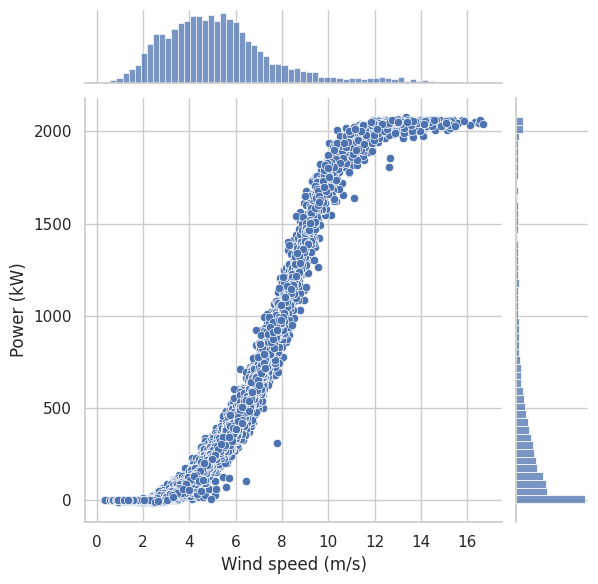

Windturbine #1
correlation between wind speed and energy export is: 
 0.9100
Turbine was 'aus dem Wind gedreht': 
 5523


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

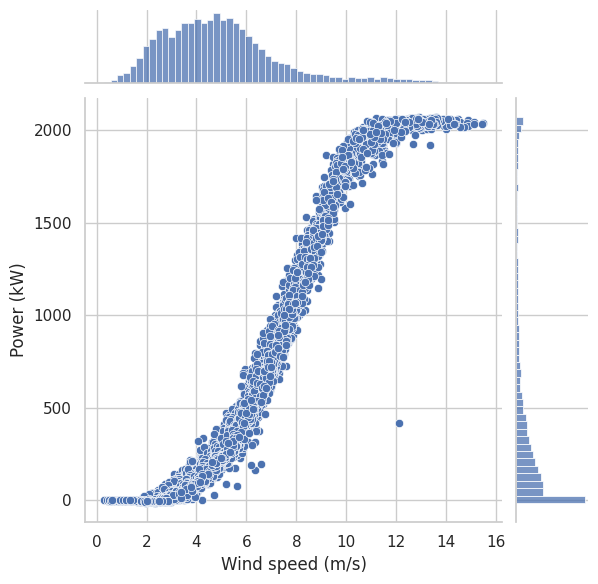

Windturbine #3
correlation between wind speed and energy export is: 
 0.9132
Turbine was 'aus dem Wind gedreht': 
 5681


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

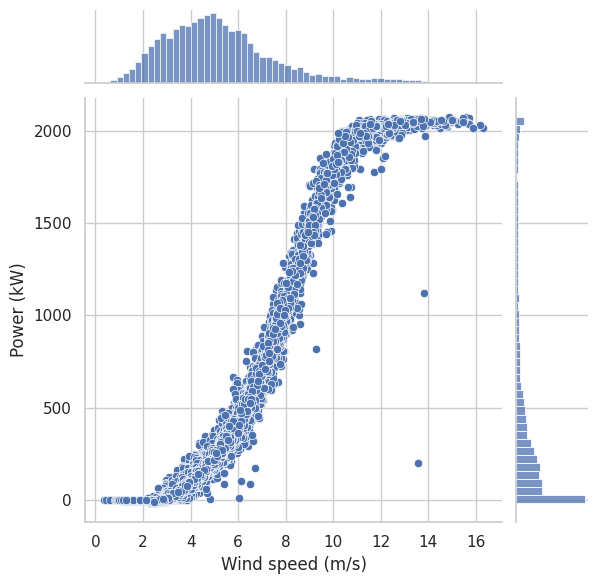

Windturbine #2
correlation between wind speed and energy export is: 
 0.9240
Turbine was 'aus dem Wind gedreht': 
 4066


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

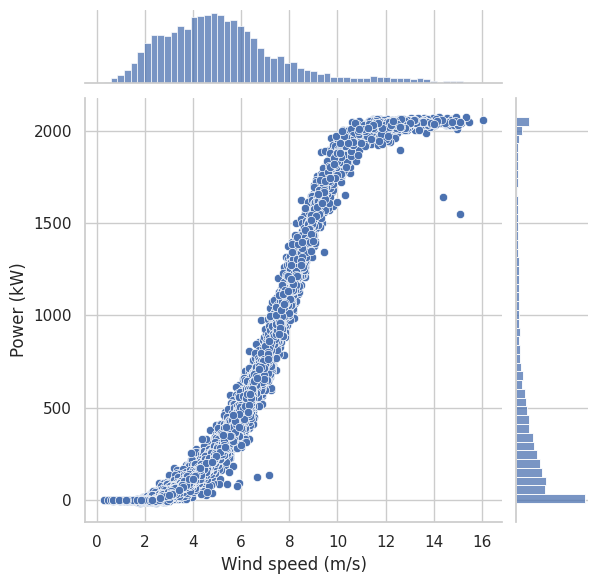

Windturbine #5
correlation between wind speed and energy export is: 
 0.8964
Turbine was 'aus dem Wind gedreht': 
 6179


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

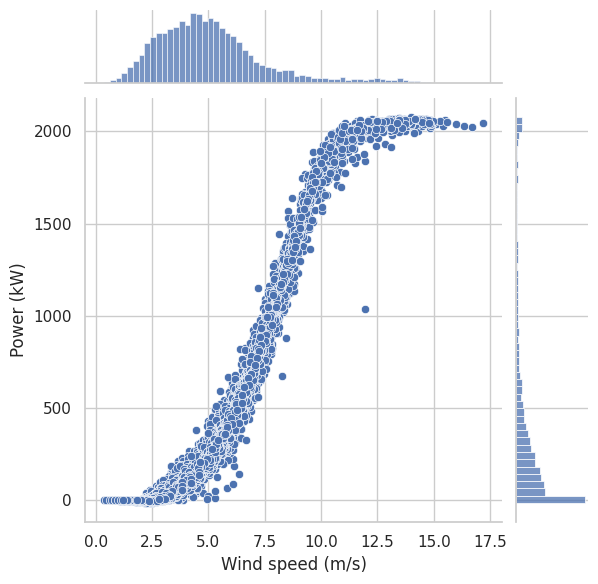

<Figure size 640x480 with 0 Axes>

In [106]:
for key in Kelmarsh_df.keys():
    print(f"Windturbine #{key}")
    wind_energy_corr(Kelmarsh_df[key])

### stationarity test

don't run - takes ~10 minutes with 12 cores

In [ ]:
%%script false --no-raise-error


# Assuming turbine_dataframes is a dictionary with your DataFrames
for turbine, df in Kelmarsh_df.items():
    full_series = df['Power (kW)']

    # Extract the last 75% of the series
    series = full_series[int(0.25 * len(full_series)):]
    
    # Perform the Augmented Dickey-Fuller test
    result = adfuller(series.dropna()) # Drop NaN values if necessary

    # Extract the p-value
    p_value = result[1]

    # Determine whether to reject the null hypothesis (non-stationary)
    if p_value < 0.05:
        print(f'{turbine}: Time series is likely stationary (p={p_value})')
    else:
        print(f'{turbine}: Time series is likely non-stationary (p={p_value})')

all time series have a p-value < 0.05 and are thus likely stationary.

Hence no additional steps have to be undertaken to use the time series at hand.

### Results table

In [107]:
# metrics function
def compute_metrics(df, column_name='Power (kW)'):
    # Number of values
    total_values = len(df[column_name])
    
    # Missing values
    missing_values = df[column_name].isna().sum()
    
    # Z-scores for outlier detection
    mean = df[column_name].mean()
    std_dev = df[column_name].std()
    z_scores = (df[column_name] - mean) / std_dev

    # Number of outliers and highest z-score
    outliers = z_scores[np.abs(z_scores) > 2]
    num_outliers = len(outliers)
    highest_z_score = outliers.abs().max() if num_outliers > 0 else 0

    return [total_values, missing_values, num_outliers, highest_z_score]

# apply function to df
summary_data = []

# Loop for Kelmarsh_df
for turbine, df in Kelmarsh_df.items():
    metrics = compute_metrics(df)
    summary_data.append(['Kelmarsh', turbine] + metrics)

# Loop for Penmanshiel_df
for turbine, df in Penmanshiel_df.items():
    metrics = compute_metrics(df)
    summary_data.append(['Penmanshiel', turbine] + metrics)

# Convert to a summary DataFrame
summary_df = pd.DataFrame(summary_data, columns=['Location', 'Turbine', 'Total Values', 'Missing Values', 'Outliers', 'Highest Z-Score'])

summary_df

,Location,Turbine,Total Values,Missing Values,Outliers,Highest Z-Score
0,Kelmarsh,6,280025,385,0,0
1,Kelmarsh,4,280773,378,0,0
2,Kelmarsh,1,282240,340,0,0
3,Kelmarsh,3,281157,342,0,0
4,Kelmarsh,2,282495,312,0,0
5,Kelmarsh,5,281685,387,0,0
6,Penmanshiel,07,267014,5881,0,0
7,Penmanshiel,08,259106,6552,0,0
8,Penmanshiel,02,266923,6114,0,0
9,Penmanshiel,05,265135,4134,0,0


### feature engineering Fraunhofer

trend and seasonal decomposition is not investigated, to make it harder for the Models to predict

In [ ]:
FraunhoferData['Hiller'].head()

,Zeitstempel,1.0 - Trafo 1 [Wh],"1.1 - Neubau, Wohnhaus, Holzplatz [Wh]",1.2 - Halle 3/1 Absaugung [Wh],1.3 - Halle 4/2 Maschinensaal/Tischfertigung [Wh],"1.4 - Halle 2/2 Verwaltung, Entwicklung [Wh]",1.5 - Halle 4/5 Lackieranlage [Wh],1.6 - Halle 1/6 Hausmeister [Wh],"1.7 - Halle 3/3 Kompressor, Stuhlmontage [Wh]",2.0 - Trafo 2 [Wh],2.1 - Halle 4/5 Schrankfertigung [Wh],2.2 - Halle 2/4 Rilsan [Wh],2.3 - Halle 4/5 Stahlstuhl [Wh],2.4 - Halle 4/1 Schichtholz [Wh],2.5 - Halle 4/1 Absaugung Schichtholz [Wh],2.6 - Halle 3/6a Schlatter [Wh],Übergabezähler [Wh],1.8 - Residual,2.7 - Residual,0.1 - Residual
0,2022-01-01 00:15:00,2490.59,820.04,30.04,596.89,3064.04,0.11,136.98,205.81,3960.94,250.94,547.34,598.18,64.50,54.85,0.0,0.0,-2157.51,2445.13,-6451.53
1,2022-01-01 00:30:00,2416.07,677.48,29.32,651.33,3050.03,0.06,90.86,202.52,3872.87,279.26,537.12,571.65,63.96,53.31,0.0,0.0,-2083.01,2367.57,-6288.94
2,2022-01-01 00:45:00,2410.21,640.79,29.18,752.23,3020.57,0.10,92.29,194.06,3874.72,275.07,529.85,551.04,63.60,53.24,0.0,20000.0,-2124.95,2401.92,13715.07
3,2022-01-01 01:00:00,2525.85,715.91,29.27,612.53,3324.27,0.03,115.20,197.47,4035.20,276.31,537.56,553.50,63.96,53.54,0.0,0.0,-2271.36,2550.33,-6561.05
4,2022-01-01 01:15:00,2534.66,657.07,29.32,710.75,3322.08,0.04,110.17,202.56,4052.54,275.54,531.48,548.32,63.81,53.24,0.0,0.0,-2294.77,2580.15,-6587.20


In [108]:
# add time variables

# Extract day of the week
FraunhoferData['Hiller']['day_of_week'] = FraunhoferData['Hiller']['Zeitstempel'].dt.day_name()

# Extract season
def get_season(date):
    if (date.month == 3 and date.day >= 20) or (date.month == 4 or date.month == 5) or (date.month == 6 and date.day < 21):
        return 'Spring'
    elif (date.month == 6 and date.day >= 21) or (date.month == 7 or date.month == 8) or (date.month == 9 and date.day < 22):
        return 'Summer'
    elif (date.month == 9 and date.day >= 22) or (date.month == 10 or date.month == 11) or (date.month == 12 and date.day < 21):
        return 'Autumn'
    else:
        return 'Winter'

FraunhoferData['Hiller']['season'] = FraunhoferData['Hiller']['Zeitstempel'].apply(get_season)

# Get German public holidays for recent years
german_holidays = holidays.Germany(years=[2019, 2020, 2021, 2022, 2023])

# Create a new column indicating whether the date is a public holiday
FraunhoferData['Hiller']['public_holiday'] = FraunhoferData['Hiller']['Zeitstempel'].dt.date.isin(german_holidays).astype(int)

In [109]:
def time_features(df: pd.DataFrame, state: str = None) -> pd.DataFrame:
    # Ensure the eitstempel column is a datetime object
    df['Zeitstempel'] = pd.to_datetime(df['Zeitstempel'], format='%d.%m.%Y %H:%M:%S')

    # Add day of the week column
    df['day_of_week'] = df['Zeitstempel'].dt.day_name()

    # Add season column based on month
    def get_season(month):
        if 3 <= month <= 5:
            return "Spring"
        elif 6 <= month <= 8:
            return "Summer"
        elif 9 <= month <= 11:
            return "Autumn"
        else:
            return "Winter"

    df['season'] = df['Zeitstempel'].dt.month.apply(get_season)

    # Get German public holidays for recent years, including regional holidays for specified state
    years_to_consider = list(range(df['Zeitstempel'].dt.year.min(), df['Zeitstempel'].dt.year.max() + 1))
    german_holidays = holidays.Germany(years=years_to_consider, prov=state)

    # Create a new column indicating whether the date is a public holiday or weekend
    df['Weekday_end'] = df.apply(lambda row: "Weekend" if row['Zeitstempel'].date() in german_holidays or row['day_of_week'] in ['Saturday', 'Sunday'] else "Weekday", axis=1)

    return df

# Call the function with Bavaria as the state
time_features(FraunhoferData['Hiller'], "BY")[['Zeitstempel', 'day_of_week', 'season', 'Weekday_end']].head()

,Zeitstempel,day_of_week,season,Weekday_end
Zeitstempel,,,,
2022-01-01 00:15:00,2022-01-01 00:15:00,Saturday,Winter,Weekend
2022-01-01 00:30:00,2022-01-01 00:30:00,Saturday,Winter,Weekend
2022-01-01 00:45:00,2022-01-01 00:45:00,Saturday,Winter,Weekend
2022-01-01 01:00:00,2022-01-01 01:00:00,Saturday,Winter,Weekend
2022-01-01 01:15:00,2022-01-01 01:15:00,Saturday,Winter,Weekend


# calculate AR

for complexity

In [110]:
from statsmodels.graphics.tsaplots import plot_acf

def AC_coefficient(data, dependent_var):
    # Load your time series data into a pandas Series (if it's not already)
    time_series = pd.Series(data[dependent_var][-1000:].values, index=data[-1000:].index).dropna()

    # Plot the ACF
    plot_acf(time_series)
    plt.show()

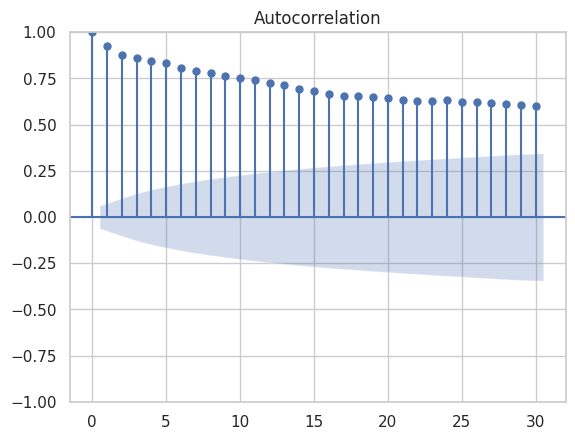

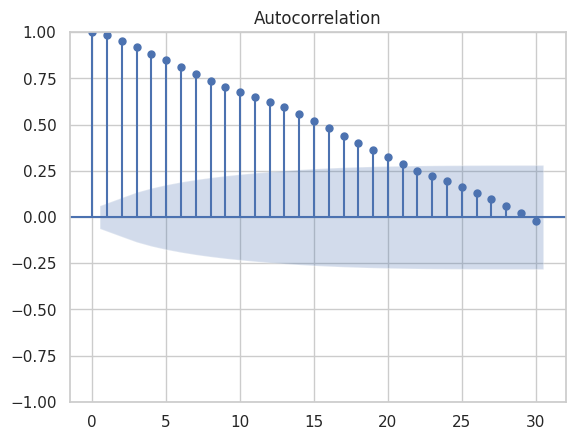

In [111]:
AC_coefficient(Kelmarsh_df['1'], 'Power (kW)')

AC_coefficient(FraunhoferData['Hiller'], '1.0 - Trafo 1 [Wh]')

# save files

In [ ]:
%store Kelmarsh_df Penmanshiel_df FraunhoferData

Stored 'Kelmarsh_df' (defaultdict)
Stored 'Penmanshiel_df' (defaultdict)


# Test-Area